## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Get a Census API key and replace it in the cell below

In [4]:
%%R 

census_api_key("TKTKTKTK") # <- Insert your Census API key here

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Once you've found the variable or variables you want, you can plug them into this code under `variables`. 

In [5]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/

# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",     # population
                        total_units = "B25001_001",  # housing units
                        med_inc="B19013_001"         # median income
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

nyc_census_data


  |======================================================================| 100%
Simple feature collection with 6981 features and 5 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME    variable estimate
1  36081014700  Census Tract 147, Queens County, New York  population     2863
2  36081014700  Census Tract 147, Queens County, New York     med_inc    71815
3  36081014700  Census Tract 147, Queens County, New York total_units     1570
4  36047058400   Census Tract 584, Kings County, New York  population     3655
5  36047058400   Census Tract 584, Kings County, New York     med_inc    67315
6  36047058400   Census Tract 584, Kings County, New York total_units     1498
7  36061006900 Census Tract 69, New York County, New York  population     2450
8  36061006900 Census Tract 69, New York C

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [6]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  # pivot from wide to long
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

nyc_census_data

Simple feature collection with 2327 features and 8 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 9
   GEOID    NAME                   geometry population_estimate med_inc_estimate
   <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608101… Cens… (((-73.9137 40.76548, -7…                2863            71815
 2 3604705… Cens… (((-73.96103 40.59616, -…                3655            67315
 3 3606100… Cens… (((-74.02064 40.73039, -…                2450           237500
 4 3604707… Cens… (((-73.93345 40.6257, -7…                2676           117857
 5 3604710… Cens… (((-73.90735 40.63083, -…                3004            76207
 6 3604705… Cens… (((-73.96279 40.72256, -…                1834           107410
 7 3600502… Cens… (((-73.92012 40.83759, -…                4030            37200
 8 3608104… Cens… (((-73

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

In this example, we create a column called `borough` by extracting the borough from the `NAME` column.

_(hint, I used GitHub Copilot -- a tool similar to ChatGPT -- to do this...see my prompt in the comments)_

In [7]:
%%R 

# Extract borough name from NAME by splitting strings like 
# "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim()
    ) 

nyc_census_data

Simple feature collection with 2327 features and 9 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 10
   GEOID    NAME                   geometry population_estimate med_inc_estimate
 * <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608101… Cens… (((-73.9137 40.76548, -7…                2863            71815
 2 3604705… Cens… (((-73.96103 40.59616, -…                3655            67315
 3 3606100… Cens… (((-74.02064 40.73039, -…                2450           237500
 4 3604707… Cens… (((-73.93345 40.6257, -7…                2676           117857
 5 3604710… Cens… (((-73.90735 40.63083, -…                3004            76207
 6 3604705… Cens… (((-73.96279 40.72256, -…                1834           107410
 7 3600502… Cens… (((-73.92012 40.83759, -…                4030            37200
 8 3608104… Cens… (((-7

### Step 5 | Example Plots

Let's practice with histograms

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 131 rows containing non-finite values (`stat_bin()`). 



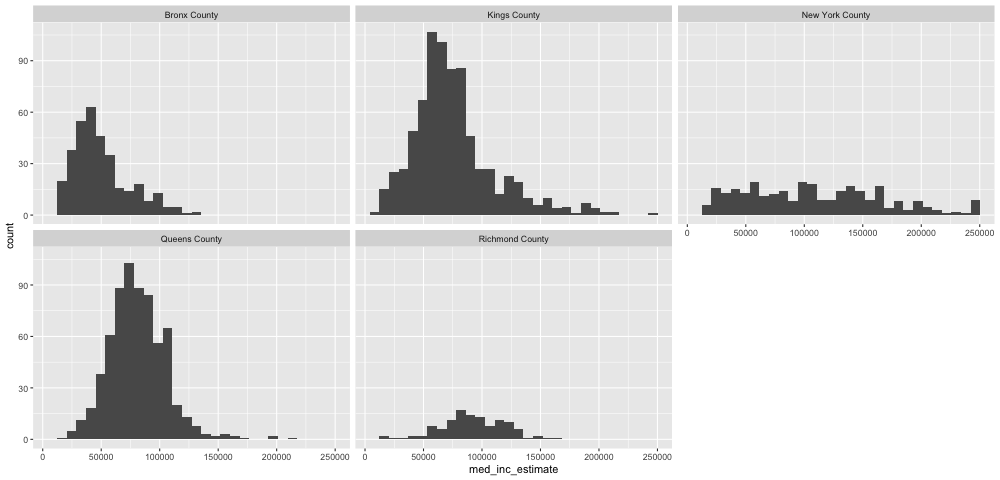

In [8]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=med_inc_estimate) +
    geom_histogram() + 
    facet_wrap(~borough) 

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 131 rows containing non-finite values (`stat_boxplot()`). 

R[write to console]: 2: Removed 131 rows containing missing values (`geom_point()`). 



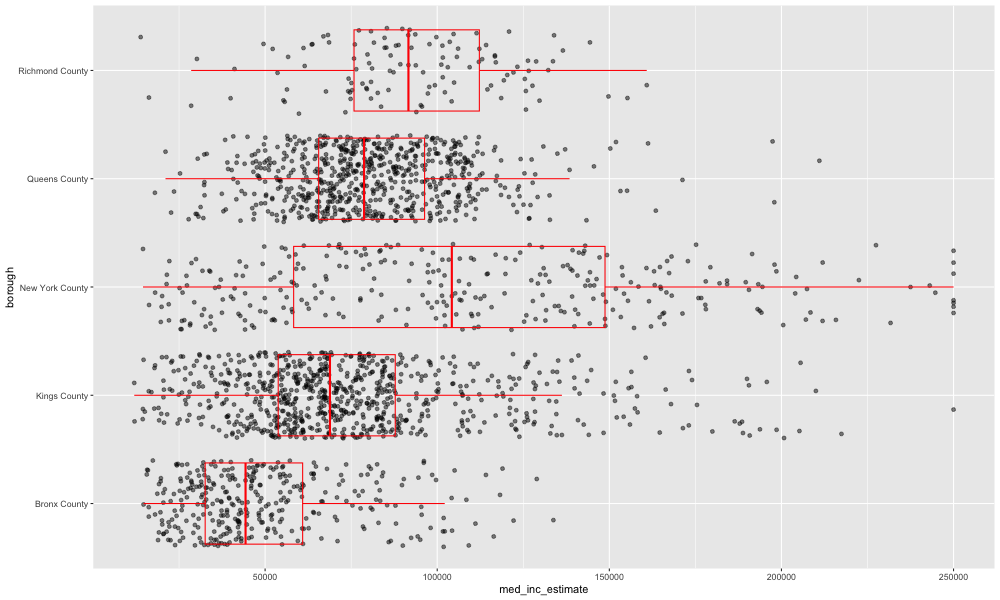

In [9]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=med_inc_estimate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

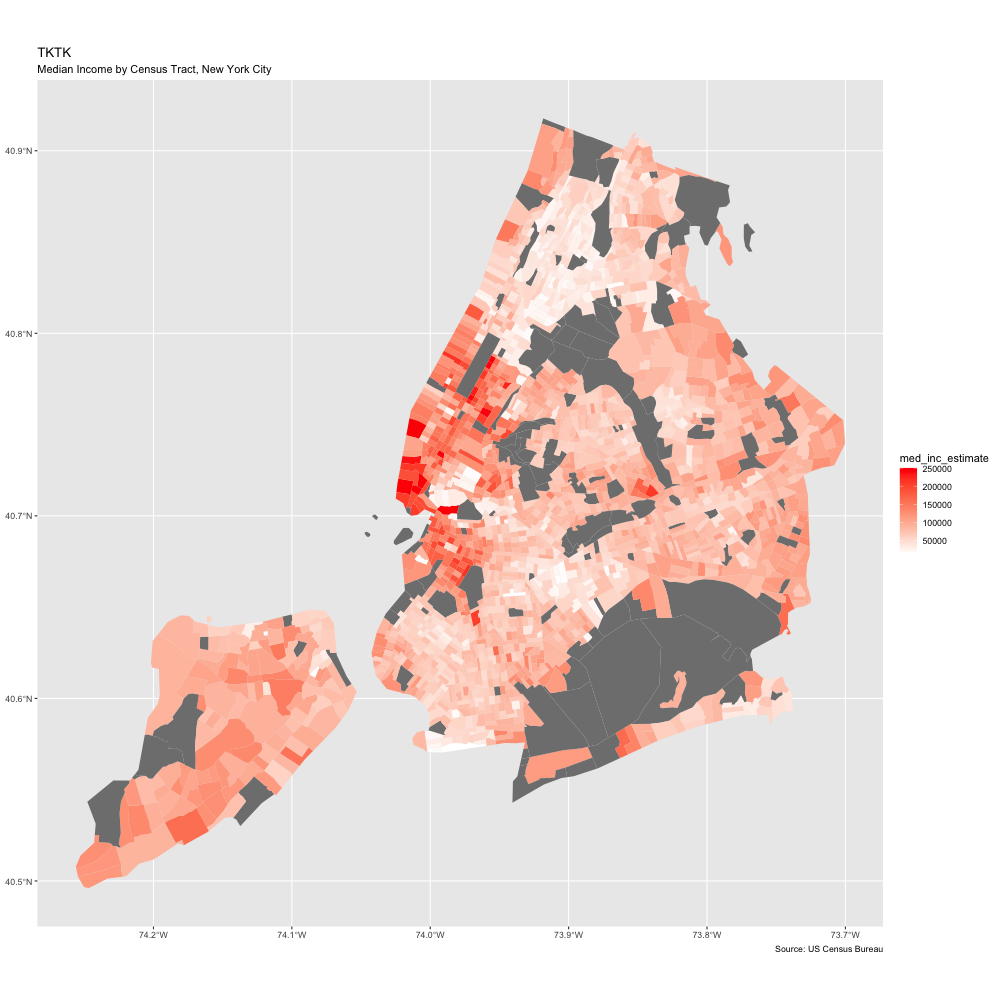

In [10]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = med_inc_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "TKTK",
    subtitle = "Median Income by Census Tract, New York City",
    caption = "Source: US Census Bureau"
  )


# Step 7 | Your Turn

- 👉 Here are the various [geographies you can use with tidycensus](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus). Try changing the analysis from the census tract level to the something more granular like `block group`. What do you notice that you didn't when looking at the tract-level data?

- 👉 Pick a different variable other than median income and re-run the notebook. Use [https://censusreporter.org/](https://censusreporter.org) figure out what variable or variables you'd like to explore and add them to the list in **step 2**. 

    *hint*: Remember, you can create new columns in **step 5** using `mutate`. For example, the following code would both split the borough out of the NAME column, and also 

    ```r
    nyc_census_data <- nyc_census_data %>% 
        mutate(
            borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
            units_per_person = total_unitstotal_units_estimate / population_estimate
        ) 

    nyc_census_data
    ```